<a href="https://colab.research.google.com/github/Konstantinosil/Chortareas-Linardatos-Central-Bank-Credibility-in-Comparative-Perspective-Framework-and-Evidence/blob/main/US_EA_UK%2C_Central_Bank_Credibility_in_Comparative_Perspective_Framework_and_Evidence%2C_Chortareas_%26_Linardatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Frequency audit of /content/chapter 2.xlsx ===
                         sheet    n infer_freq                                              top_day_gaps value_cols
              Policy Rates EU 5145          D                                             [(1.0, 5144)]   [POLICY]
                 Inflation EU  169         MS           [(31.0, 98), (30.0, 56), (28.0, 10), (29.0, 4)]      [INF]
                Volatility EU 3584       None [(1.0, 2836), (3.0, 700), (5.0, 23), (4.0, 14), (2.0, 6)]      [VOL]
                      RGDP EU   53     QS-OCT                       [(92.0, 26), (91.0, 17), (90.0, 9)]      [GDP]
Composite Leader Indicator EU  169         MS           [(31.0, 98), (30.0, 56), (28.0, 10), (29.0, 4)]      [CLI]
              Policy Rates UK 3675          B                                 [(1.0, 2939), (3.0, 735)]   [POLICY]
                 Inflation UK  169         MS           [(31.0, 98), (30.0, 56), (28.0, 10), (29.0, 4)]      [INF]
                Volatility U

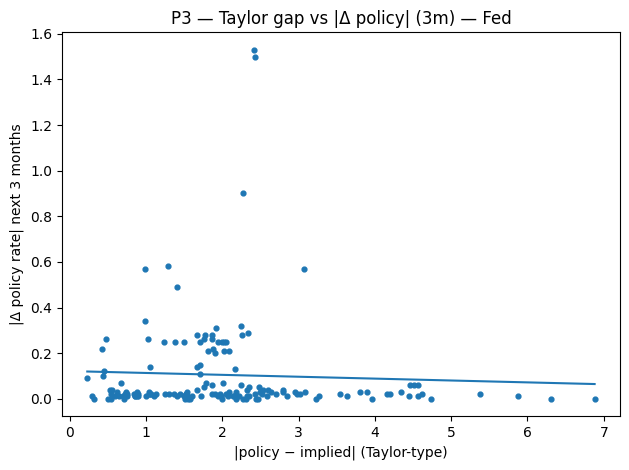

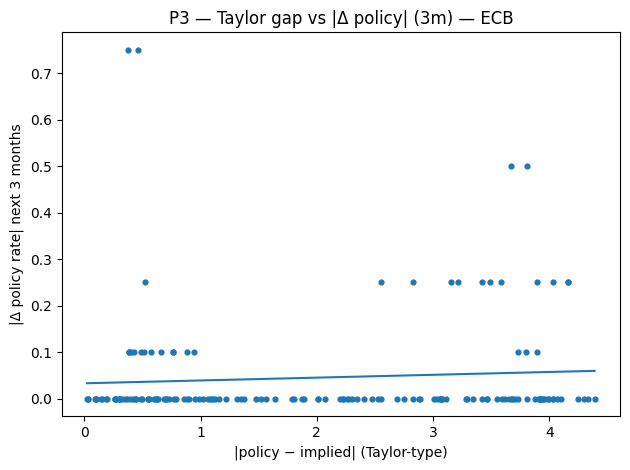

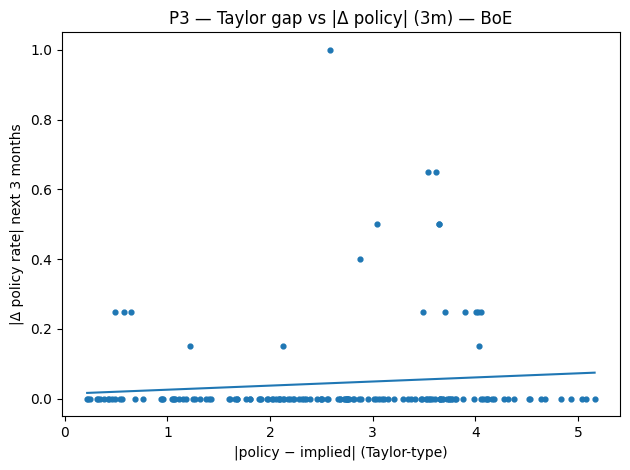

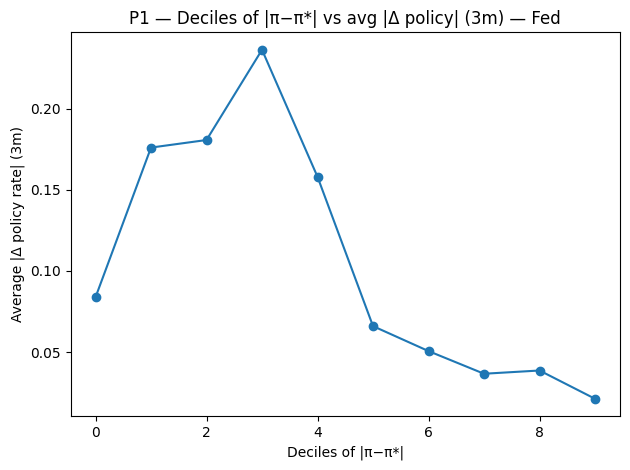

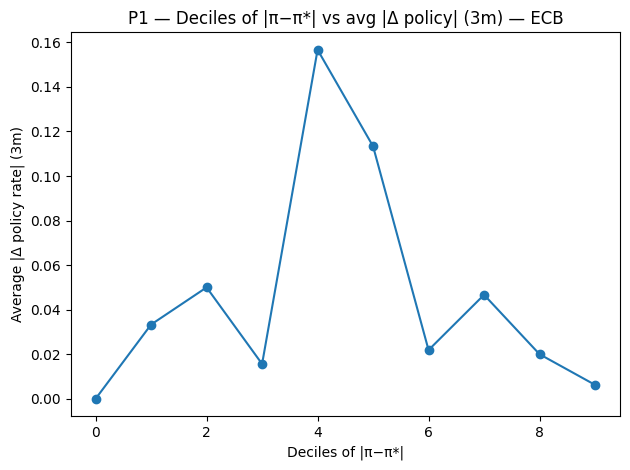

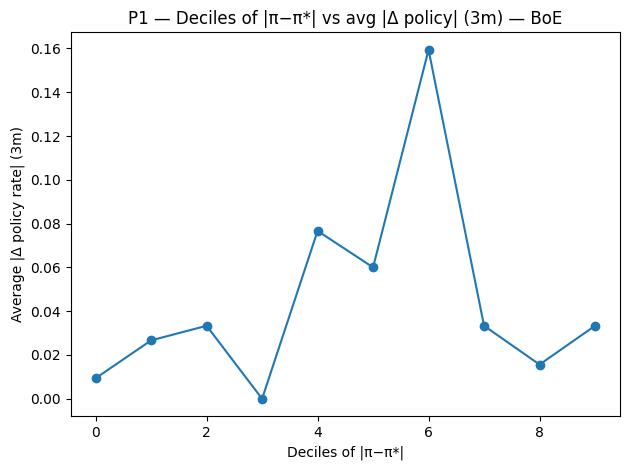


[Benjamini–Hochberg FDR @10%]
P3 base:taylor_gap  p=0.364  q=0.547
P3 FE:taylor_gap  p=0.678  q=0.805
P3 lag:taylor_gap_lag1  p=0.196  q=0.547
P3e:taylor_gap_simple_z  p=0.057  q=0.344
P3e CLI:taylor_gap_cli  p=0.298  q=0.547
P4 base:abs_infl_gap  p=0.805  q=0.805

DONE.


In [ ]:
import os, re, warnings, itertools, math, random
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
try:
    from linearmodels.panel import PanelOLS
    HAS_LM = True
except Exception:
    HAS_LM = False
try:
    from scipy import stats as sps
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False
ROOT = "/content"
if not os.path.exists(os.path.join(ROOT, "chapter 2.xlsx")):
    ROOT = "/mnt/data"
XLS_MAIN = os.path.join(ROOT, "chapter 2.xlsx")
TEXT_US  = os.path.join(ROOT, "text data us.xlsx")
TEXT_EU  = os.path.join(ROOT, "text data eu.xlsx")
TEXT_UK  = os.path.join(ROOT, "text data uk.xlsx")
START = pd.Timestamp("2008-01-01")
END   = pd.Timestamp("2022-12-31")
PI_STAR = 2.0
R_STAR  = 1.0
PHI_PI  = 1.5
PHI_Y   = 0.5
RHO     = 0.8
HAC_LAGS_3M = 6
HAC_LAGS_6M = 12
ELB_EPS     = 0.10
NZ_MOVE_BPS = 5
WINSOR_P    = 0.01
SEED        = 123
np.random.seed(SEED)
random.seed(SEED)
def winsorize(df, cols, p=0.01):
    z = df.copy()
    for c in cols:
        if c in z:
            lo, hi = z[c].quantile([p, 1-p])
            z[c] = z[c].clip(lo, hi)
    return z
def freq_audit(xls_path):
    rows=[]
    xls = pd.ExcelFile(xls_path)
    for sh in xls.sheet_names:
        d = pd.read_excel(xls_path, sheet_name=sh)
        if "Date" not in d.columns:
            continue
        d["Date"] = pd.to_datetime(d["Date"])
        n = len(d)
        try: freq = pd.infer_freq(d["Date"].sort_values().dropna())
        except: freq = None
        gaps = d["Date"].sort_values().diff().dt.days.value_counts().head(5)
        valcols = [c for c in d.columns if c!="Date"]
        rows.append([sh, n, freq, list(zip(gaps.index.tolist(), gaps.values.tolist())), valcols])
    out = pd.DataFrame(rows, columns=["sheet","n","infer_freq","top_day_gaps","value_cols"])
    print("=== Frequency audit of", xls_path, "===\n", out.to_string(index=False))
    return out
def smooth_series(s, rho=RHO):
    out=[]; prev=np.nan
    for x in s.astype(float).values:
        if np.isnan(x):
            out.append(np.nan)
        elif np.isnan(prev) or rho==0.0:
            val = x
            out.append(val); prev = val
        else:
            val = (1-rho)*x + rho*prev
            out.append(val); prev = val
    return pd.Series(out, index=s.index)
def andrews_auto_lags(T):
    if T is None or T<=0:
        return 6
    return max(1, int(round(4.0*(T/100.0)**(2.0/9.0))))
def im_inference(df, y, X, param, add_fe_year=True, add_fe_month=False, hac_lags=6):
    betas=[]
    banks = sorted(df["bank"].dropna().unique().tolist())
    for b in banks:
        z = df[df["bank"]==b].dropna(subset=[y]+X).copy()
        if z.empty:
            continue
        z["const"]=1.0
        mats=[z[["const"]+X].astype(float)]
        if add_fe_year and "year" in z:
            mats.append(pd.get_dummies(z["year"], prefix="y", drop_first=True))
        if add_fe_month and "month" in z:
            mats.append(pd.get_dummies(z["month"], prefix="m", drop_first=True))
        Xmat = pd.concat(mats, axis=1).astype(float)
        res  = sm.OLS(z[y].astype(float), Xmat).fit(cov_type="HAC", cov_kwds={"maxlags":hac_lags})
        if param in res.params.index:
            betas.append(float(res.params[param]))
    G=len(betas); mean_b=np.mean(betas) if betas else np.nan
    sd_b=np.std(betas, ddof=1) if G>=2 else np.nan
    if G>=2 and np.isfinite(sd_b) and sd_b>0:
        t = np.sqrt(G)*mean_b/sd_b
        if HAS_SCIPY:
            p = 2*(1 - sps.t.cdf(np.abs(t), df=G-1))
        else:
            p = 2*(1 - 0.5*(1+math.erf(np.abs(t)/np.sqrt(2))))
    else:
        t, p = np.nan, np.nan
    out = {"G":G,"mean_beta":mean_b,"sd_beta":sd_b,"t_IM":t,"p_IM":p,"bank_betas":dict(zip(banks, betas))}
    return out
def exact_sign_randomization(betas):
    b = np.array(list(betas.values()), dtype=float)
    G = len(b); obs = abs(b.mean())
    if G==0:
        return np.nan
    cnt = 0; ge = 0
    for mask in range(1<<G):
        w = np.array([1 if ((mask>>i)&1)==1 else -1 for i in range(G)], dtype=float)
        m = abs((w*b).mean())
        ge += (m >= obs)
        cnt += 1
    return ge/cnt
def bh_adjust(pvals, alpha=0.10):
    ps = np.array(pvals, dtype=float); n = len(ps)
    order = np.argsort(ps); ranks = np.arange(1, n+1)
    q = np.empty(n); q.fill(np.nan)
    prev = 1.0
    for idx, r in zip(order[::-1], ranks[::-1]):
        val = min(prev, ps[idx]*n/r)
        q[idx] = val; prev = val
    return q
def read_block(sheet, bank, value_col):
    d = pd.read_excel(XLS_MAIN, sheet_name=sheet)
    d = d.rename(columns={"Date":"date", value_col:value_col})
    d["date"] = pd.to_datetime(d["date"])
    x = pd.to_numeric(d[value_col], errors="coerce")
    if x.notna().mean() < 0.5:
        raw = d[value_col].astype(str)
        x = (raw
             .str.replace("%","", regex=False)
             .str.replace("\u2212","-", regex=False)
             .str.replace(" ", "", regex=False)
             .str.replace(",", ".", regex=False))
        x = pd.to_numeric(x, errors="coerce")
    d[value_col] = x
    d["bank"] = bank
    return d[["date","bank", value_col]].sort_values("date")
def read_all():
    eu_pol = read_block("Policy Rates EU","ECB","POLICY")
    eu_inf = read_block("Inflation EU","ECB","INF")
    eu_vol = read_block("Volatility EU","ECB","VOL")
    eu_gdp = read_block("RGDP EU","ECB","GDP")
    eu_cli = read_block("Composite Leader Indicator EU","ECB","CLI")
    uk_pol = read_block("Policy Rates UK","BoE","POLICY")
    uk_inf = read_block("Inflation UK","BoE","INF")
    uk_vol = read_block("Volatility UK","BoE","VOL")
    uk_gdp = read_block("RGDP UK","BoE","GDP")
    uk_cli = read_block("Composite Leader Indicator UK","BoE","CLI")
    us_pol = read_block("Policy Rates US","Fed","POLICY")
    us_inf = read_block("Inflation US","Fed","INF")
    us_vol = read_block("Volatility US","Fed","VOL")
    us_gdp = read_block("RGDP US","Fed","GDP")
    us_cli = read_block("Composite Leader Indicator US","Fed","CLI")
    pol = pd.concat([eu_pol, uk_pol, us_pol], ignore_index=True)
    inf = pd.concat([eu_inf, uk_inf, us_inf], ignore_index=True)
    vol = pd.concat([eu_vol, uk_vol, us_vol], ignore_index=True)
    gdp = pd.concat([eu_gdp, uk_gdp, us_gdp], ignore_index=True)
    cli = pd.concat([eu_cli, uk_cli, us_cli], ignore_index=True)
    return pol, inf, vol, gdp, cli
def to_monthly_panel(elb_eps=ELB_EPS):
    pol, inf, vol, gdp, cli = read_all()
    def infer_yoy_from_INF(series):
        s = pd.to_numeric(series, errors="coerce")
        med = s.median()
        return s.pct_change(12, fill_method=None)*100.0 if (np.isfinite(med) and med>30) else s
    res = []
    for b in ["ECB","BoE","Fed"]:
        gpol = pol[pol["bank"]==b].set_index("date").sort_index()
        m_pol = gpol["POLICY"].resample("ME").last()
        gvol = vol[vol["bank"]==b].set_index("date").sort_index()
        m_vol = gvol["VOL"].resample("ME").mean()
        ginf = inf[inf["bank"]==b].set_index("date").sort_index()
        m_inf = ginf["INF"].resample("ME").last()
        m_infl_yoy = infer_yoy_from_INF(m_inf)
        gcli = cli[cli["bank"]==b].set_index("date").sort_index()
        m_cli = gcli["CLI"].resample("ME").last()
        ggdp = gdp[gdp["bank"]==b].copy()
        ggdp["GDP"] = pd.to_numeric(ggdp["GDP"], errors="coerce")
        ggdp = ggdp.set_index("date").sort_index()
        q_end = ggdp.copy()
        q_end.index = q_end.index.to_period("Q").to_timestamp("Q")
        m_gdp = q_end["GDP"].resample("M").interpolate("linear").resample("ME").last()
        mm = pd.concat([m_pol, m_vol, m_infl_yoy, m_cli, m_gdp], axis=1)
        mm.columns = ["policy_rate","volatility","infl_yoy","cli","gdp"]
        mm["bank"] = b
        mm = mm.reset_index().rename(columns={"index":"date"})
        res.append(mm)
    mon = pd.concat(res, ignore_index=True)
    mon = mon[(mon["date"]>=START) & (mon["date"]<=END)].copy()
    mon = mon.sort_values(["bank","date"])
    outs=[]
    for b, g in mon.groupby("bank", sort=False):
        gg = g.copy()
        gg["gdp"] = pd.to_numeric(gg["gdp"], errors="coerce").ffill().bfill()
        gg["log_gdp"] = np.log(gg["gdp"])
        _, trend = hpfilter(gg["log_gdp"].values, lamb=129600)
        gg["output_gap"] = (gg["log_gdp"].values - trend)*100.0
        outs.append(gg)
    mon = pd.concat(outs, ignore_index=True)
    mon["cli_gap_z"] = (mon["cli"] - mon.groupby("bank")["cli"].transform("mean"))/mon.groupby("bank")["cli"].transform("std")
    mon["inflation_gap"] = pd.to_numeric(mon["infl_yoy"], errors="coerce") - PI_STAR
    mon["year"]  = mon["date"].dt.year
    mon["month"] = mon["date"].dt.month
    mon["ym"]    = mon["date"].dt.to_period("M")
    mon["mnum"]  = mon["ym"].astype(int)
    mon["crisis10"] = mon["year"].between(2010, 2012).astype(int)
    mon["pandem"]   = mon["year"].between(2020, 2021).astype(int)
    def qe_flag(b, y):
        if pd.isna(y): return 0
        y = int(y)
        if b=="ECB": return int((2015<=y<=2018) or (2020<=y<=2021))
        if b=="BoE": return int((2009<=y<=2012) or (2020<=y<=2021))
        if b=="Fed": return int((2009<=y<=2014) or (2020<=y<=2021))
        return 0
    mon["QE_FG"] = mon.apply(lambda r: qe_flag(r["bank"], r["year"]), axis=1)
    def elb_flag_simple(bank, i):
        if pd.isna(i): return 0
        return int(i <= (0.05 if bank=="ECB" else 0.25))
    mon["ELB_simple"] = mon.apply(lambda r: elb_flag_simple(r["bank"], r["policy_rate"]), axis=1)
    def elb_data_driven(g, eps=elb_eps):
        roll_min = g["policy_rate"].rolling(24, min_periods=6).min()
        return (g["policy_rate"] <= (roll_min + eps)).astype(int)
    mon["ELB_alt"] = mon.groupby("bank", sort=False).apply(elb_data_driven).reset_index(level=0, drop=True)
    mon["ELB"] = mon["ELB_alt"]
    return mon
HEDGES=set("""may might could would should if possibly perhaps likely unlikely uncertainty uncertain risk risks downside upside around approximately roughly broadly somewhat nearly""".split())
def sent_split(t): return [s for s in re.split(r"[.!?]+", t) if s.strip()]
_vowels = "aeiouy"
def count_syllables(word):
    w = re.sub(r"[^a-z]", "", word.lower())
    if not w: return 0
    syl = 0; prev_v = False
    for ch in w:
        isv = ch in _vowels
        if isv and not prev_v: syl += 1
        prev_v = isv
    if w.endswith("e") and syl>1: syl -= 1
    return max(syl,1)
def readability_scores(text):
    t = re.sub(r"\s+"," ",str(text)).strip()
    sents = [s for s in re.split(r"[.!?]+", t) if s.strip()]
    words = re.findall(r"[A-Za-z']+", t)
    n_s = max(len(sents),1); n_w = max(len(words),1)
    n_sy = sum(count_syllables(w) for w in words)
    fre = 206.835 - 1.015*(n_w/n_s) - 84.6*(n_sy/n_w)
    return fre, n_w, n_s
def text_metrics(txt):
    t = re.sub(r"\s+"," ",str(txt)).strip().lower()
    sents = sent_split(t)[:5]
    words = re.findall(r"[a-zA-Z']+"," ".join(sents))
    n = max(len(words),1); k = max(len(sents),1)
    fre, n_w_all, n_s_all = readability_scores(txt)
    return pd.Series({
        "avg_sentence_len": n/k,
        "avg_word_len": np.mean([len(w) for w in words]) if words else 0.0,
        "hedge_ratio": sum(1 for w in words if w in HEDGES)/n,
        "modal_share": sum(1 for w in words if w in {"may","might","could","would","should"})/n,
        "n_words": n,
        "FRE": fre
    })
def build_statement_clarity(mon):
    files = {"Fed":(TEXT_US,"US"), "ECB":(TEXT_EU,"Eurozone"), "BoE":(TEXT_UK,"UK")}
    rows=[]
    for b,(path,sh) in files.items():
        df = pd.read_excel(path, sheet_name=sh, parse_dates=["Date"])
        df["Text"] = df["Text"].fillna("")
        m  = df["Text"].apply(text_metrics)
        out= pd.concat([df[["Date","Text"]], m], axis=1)
        out["bank"] = b
        rows.append(out)
    ev = pd.concat(rows, ignore_index=True).rename(columns={"Date":"date"}).sort_values(["bank","date"])
    ev["ym"] = ev["date"].dt.to_period("M")
    tmp = mon.sort_values(["bank","date"]).copy()
    thr = NZ_MOVE_BPS/100.0
    tmp["DecisionMonth"] = (tmp.groupby("bank")["policy_rate"].diff().abs() >= thr)
    has_move = tmp[["bank","ym","DecisionMonth"]].drop_duplicates()
    ev = ev.merge(has_move, on=["bank","ym"], how="left").fillna({"DecisionMonth": False})
    for c in ["avg_sentence_len","avg_word_len","hedge_ratio","modal_share","FRE"]:
        mu = ev.groupby("bank")[c].transform("mean")
        sd = ev.groupby("bank")[c].transform("std")
        ev[c+"_z"] = (ev[c] - mu)/sd
    ev["ClarityIndex"] = (-ev["avg_sentence_len_z"] - ev["avg_word_len_z"] - ev["hedge_ratio_z"] - ev["modal_share_z"])/4.0
    ev["ClarityIndex_FRE"] = ev["FRE_z"]
    ev = ev.sort_values(["bank","date"])
    for col in ["ClarityIndex","ClarityIndex_FRE"]:
        ev[col+"Shock"]   = ev[col] - ev.groupby("bank")[col].transform(lambda s: s.rolling(3, min_periods=1).mean())
        mu = ev.groupby("bank")[col+"Shock"].transform("mean")
        sd = ev.groupby("bank")[col+"Shock"].transform("std")
        ev[col+"Shock_z"] = (ev[col+"Shock"] - mu)/sd
    cm = ev.groupby(["bank","ym"], as_index=False)["ClarityIndex"].mean()
    return ev, cm
def build_panel_with_clarity(elb_eps=ELB_EPS):
    mon = to_monthly_panel(elb_eps=elb_eps)
    events, clarity_m = build_statement_clarity(mon)
    mon = mon.sort_values(["bank","date"]).copy()
    mon["taylor_simple"]  = R_STAR + PI_STAR + PHI_PI*(mon["inflation_gap"]) + PHI_Y*(mon["output_gap"])
    mon["taylor_implied"] = mon.groupby("bank", group_keys=False)["taylor_simple"].apply(lambda s: smooth_series(s, RHO))
    mon["taylor_implied"] = mon["taylor_implied"].fillna(mon["taylor_simple"])
    mon["taylor_gap"]     = (mon["policy_rate"] - mon["taylor_implied"]).abs()
    mon["taylor_cli"]     = R_STAR + PI_STAR + PHI_PI*(mon["inflation_gap"]) + PHI_Y*(mon["cli_gap_z"])
    mon["taylor_cli_imp"] = mon.groupby("bank", group_keys=False)["taylor_cli"].apply(lambda s: smooth_series(s, RHO))
    mon["taylor_gap_cli"] = (mon["policy_rate"] - mon["taylor_cli_imp"]).abs()
    mon["policy_rate_lead3"] = mon.groupby("bank")["policy_rate"].shift(-3)
    mon["policy_rate_lead6"] = mon.groupby("bank")["policy_rate"].shift(-6)
    mon["abs_deltai_3m"]     = (mon["policy_rate_lead3"] - mon["policy_rate"]).abs()
    mon["abs_deltai_6m"]     = (mon["policy_rate_lead6"] - mon["policy_rate"]).abs()
    mon["abs_deltai_3m_lag"] = mon.groupby("bank")["abs_deltai_3m"].shift(1)
    mon["abs_pi_gap"] = mon["inflation_gap"].abs()
    mon["abs_y_gap"]  = mon["output_gap"].abs()
    denom = mon["abs_pi_gap"] + mon["abs_y_gap"]
    mon["pi_share"] = np.where(denom>0, mon["abs_pi_gap"]/denom, np.nan)
    p2 = mon.merge(clarity_m.rename(columns={"ym":"ym_cl"}), left_on=["bank","ym"], right_on=["bank","ym_cl"], how="left")
    p2 = p2.drop(columns=["ym_cl"]).rename(columns={"ClarityIndex":"ClarityIndex"})
    p2["cli_z"] = (p2["cli"] - p2.groupby("bank")[ "cli"].transform("mean"))/p2.groupby("bank")["cli"].transform("std")
    p2["d_vol"] = p2.groupby("bank", sort=False)["volatility"].diff()
    p2["abs_d_policy"] = p2.groupby("bank", sort=False)["policy_rate"].diff().abs()
    return mon, p2, events
def fe_ols(y, X, data, bank_fe=True, year_fe=True, month_fe=False, bank_year_fe=False, cov="HAC", hac_lags=None, label=None, return_aux=False):
    z = data.dropna(subset=[y]+X).copy()
    z["const"]=1.0
    mats=[z[["const"]+X].astype(float)]
    if bank_fe:  mats.append(pd.get_dummies(z["bank"], drop_first=True))
    if bank_year_fe and "year" in z:
        by = z["bank"].astype(str)+"_"+z["year"].astype(str)
        mats.append(pd.get_dummies(by, prefix="by", drop_first=True))
    else:
        if year_fe and "year" in z:   mats.append(pd.get_dummies(z["year"],  prefix="y", drop_first=True))
    if month_fe and "month" in z: mats.append(pd.get_dummies(z["month"], prefix="m", drop_first=True))
    Xmat = pd.concat(mats, axis=1).astype(float)
    yv = z[y].astype(float)
    if cov=="HAC":
        res = sm.OLS(yv, Xmat).fit(cov_type="HAC", cov_kwds={"maxlags":(hac_lags or 6)})
    elif cov=="cluster_bank":
        res = sm.OLS(yv, Xmat).fit(cov_type="cluster", cov_kwds={"groups": z["bank"]})
    else:
        res = sm.OLS(yv, Xmat).fit()
    if return_aux:
        return res, Xmat, yv, z
    return res
def print_core(res, title):
    if res is None:
        print(title, "— no result"); return
    print("\n"+"="*72)
    print(title)
    print("="*72)
    print(res.summary().tables[1])
def wild_cluster_bootstrap_t(res, Xmat, yv, groups, param, B=499):
    if param not in res.params.index:
        return np.nan, np.nan
    t_obs = float(res.tvalues[param])
    yhat = np.asarray(res.fittedvalues)
    u    = np.asarray(yv) - yhat
    gvals = pd.Series(groups).reset_index(drop=True).values
    gi = {}
    for i, g in enumerate(gvals):
        gi.setdefault(g, []).append(i)
    t_boot = []
    for _ in range(B):
        w = {g: (1 if np.random.rand() < 0.5 else -1) for g in gi}
        u_star = np.zeros_like(u)
        for g, idxs in gi.items():
            idxs = np.asarray(idxs, dtype=int)
            u_star[idxs] = u[idxs] * w[g]
        y_star = yhat + u_star
        res_star = sm.OLS(y_star, Xmat).fit()
        b_star   = float(res_star.params[param]); se_star  = float(res_star.bse[param])
        if np.isfinite(b_star) and np.isfinite(se_star) and se_star != 0:
            t_boot.append(b_star / se_star)
    if not t_boot:
        return t_obs, np.nan
    p_boot = float(np.mean(np.abs(np.asarray(t_boot)) >= abs(t_obs)))
    return t_obs, p_boot
def jackknife_leave_one_bank(mon, fitfun, *args, **kwargs):
    banks = sorted(mon["bank"].unique().tolist())
    out=[]
    for b in banks:
        sub = mon[mon["bank"]!=b]
        try:
            res = fitfun(sub, *args, **kwargs)
            out.append({"omit":b, "coef":res.params.to_dict()})
        except Exception:
            out.append({"omit":b, "coef":{}})
    return pd.DataFrame(out)
def panel_dk_two_way(df, y, X, entity="bank", time="date", add_const=True, entity_effects=True, time_effects=False, dk=True, clusters=None):
    if not HAS_LM:
        print("linearmodels not available — skipping DK/2-way panel inference.")
        return None
    z = df.dropna(subset=[y]+X+[entity, time]).copy()
    z = z.set_index([entity, time]).sort_index()
    if add_const:
        z["const"]=1.0; Xcols=["const"]+X
    else:
        Xcols=X
    mod = PanelOLS(z[y].astype(float), z[Xcols].astype(float), entity_effects=entity_effects, time_effects=time_effects)
    if dk:
        res = mod.fit(cov_type="kernel")
    else:
        if clusters is None:
            raise ValueError("clusters DataFrame required for 2-way clustered SE.")
        cl = clusters.loc[z.reset_index().index]
        res = mod.fit(cov_type="clustered", clusters=cl)
    return res
def resolve_collinear_pair(df, X, a, b, thr=0.98, prefer=None):
    if a not in df or b not in df:
        return X
    z = df[[a,b]].dropna()
    if z.empty:
        return X
    c = float(np.corrcoef(z[a].astype(float), z[b].astype(float))[0,1])
    if np.isfinite(c) and abs(c) >= thr:
        keep = a if prefer==a or prefer=="pandem" else (b if prefer==b else a)
        drop = b if keep==a else a
        X = [v for v in X if v != drop]
        print(f"[Collinearity] |corr({a},{b})|={abs(c):.3f} ≥ {thr} → dropping '{drop}' (keeping '{keep}')")
    return X
audit = freq_audit(XLS_MAIN)
mon, p2, events = build_panel_with_clarity(elb_eps=ELB_EPS)
for c in ["policy_rate","infl_yoy","inflation_gap","output_gap"]:
    mon[c] = pd.to_numeric(mon[c], errors="coerce")
mon = mon.sort_values(["bank","date"]).copy()
mon["taylor_simple"]  = R_STAR + PI_STAR + PHI_PI*mon["inflation_gap"] + PHI_Y*mon["output_gap"]
mon["taylor_implied"] = mon.groupby("bank", group_keys=False)["taylor_simple"].apply(lambda s: smooth_series(s, RHO))
mon["taylor_implied"] = mon["taylor_implied"].fillna(mon["taylor_simple"])
mon["taylor_gap"]     = (mon["policy_rate"] - mon["taylor_implied"]).abs()
for v in ["infl_yoy","inflation_gap","output_gap","taylor_simple","taylor_gap"]:
    print(f"[non-NaN {v}]", mon[v].notna().groupby(mon["bank"]).sum().to_dict())
for v in ["abs_deltai_3m","taylor_gap","abs_deltai_3m_lag"]:
    c = mon[v].notna().groupby(mon["bank"]).sum()
    print(f"[avail] {v}: ", c.to_dict())
reg_p3 = mon.dropna(subset=["abs_deltai_3m","taylor_gap","abs_deltai_3m_lag"]).copy()
res_p3, Xmat_p3, yv_p3, z_p3 = fe_ols("abs_deltai_3m",
                ["taylor_gap","abs_deltai_3m_lag","ELB","QE_FG","crisis10","pandem"],
                reg_p3, bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_3M,
                label="P3 baseline (HAC)", return_aux=True)
print_core(res_p3, "P3 baseline: |Δ policy| (3m) on Taylor gap + lag + ELB + QE/FG + crisis + pandemic")
t_obs_p3, p_boot_p3 = wild_cluster_bootstrap_t(res_p3, Xmat_p3, yv_p3, z_p3["bank"], "taylor_gap", B=399)
print(f"[P3] wild-cluster bootstrap t={t_obs_p3:.3f}, p_boot={p_boot_p3:.3f}")
im_p3 = im_inference(reg_p3, "abs_deltai_3m",
                     ["taylor_gap","abs_deltai_3m_lag","ELB","QE_FG","crisis10","pandem"],
                     param="taylor_gap", add_fe_year=True, add_fe_month=True, hac_lags=HAC_LAGS_3M)
print(f"[P3-IM] G={im_p3['G']}, meanβ={im_p3['mean_beta']:.4f}, t_IM={im_p3['t_IM']:.3f}, p_IM={im_p3['p_IM']:.3f}, bank betas={im_p3['bank_betas']}")
p_rand_p3 = exact_sign_randomization(im_p3["bank_betas"])
print(f"[P3-ExactRandomization] p_exact={p_rand_p3:.3f}")
def fit_p3(sub):
    return fe_ols("abs_deltai_3m",
        ["taylor_gap","abs_deltai_3m_lag","ELB","QE_FG","crisis10","pandem"],
        sub, bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_3M)
jk_p3 = jackknife_leave_one_bank(reg_p3, fit_p3)
if not jk_p3.empty:
    vals=[d.get("taylor_gap", np.nan) for d in jk_p3["coef"]]
    print("[P3] Jackknife θ_taylor_gap by omitted bank:", dict(zip(jk_p3["omit"], vals)))
res_p3_FE = fe_ols("abs_deltai_3m",
                   ["taylor_gap","abs_deltai_3m_lag","ELB","QE_FG","crisis10","pandem"],
                   reg_p3, bank_fe=True, bank_year_fe=True, month_fe=True,
                   year_fe=False, cov="HAC", hac_lags=HAC_LAGS_3M)
print_core(res_p3_FE, "P3 with bank×year FE + month FE")
reg_p3_lag = mon.copy()
reg_p3_lag["taylor_gap_lag1"] = reg_p3_lag.groupby("bank")["taylor_gap"].shift(1)
reg_p3_lag = reg_p3_lag.dropna(subset=["abs_deltai_3m","taylor_gap_lag1","abs_deltai_3m_lag"])
res_p3_lag = fe_ols("abs_deltai_3m",
                    ["taylor_gap_lag1","ELB","QE_FG","crisis10","pandem","abs_deltai_3m_lag"],
                    reg_p3_lag, bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_3M)
print_core(res_p3_lag, "P3 (lagged RHS)")
p3_noover = reg_p3[reg_p3["mnum"] % 3 == 0]
res_p3_noover = fe_ols("abs_deltai_3m",
                       ["taylor_gap","abs_deltai_3m_lag","ELB","QE_FG","crisis10","pandem"],
                       p3_noover, bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_3M)
print_core(res_p3_noover, "P3 non-overlap (every 3rd month)")
reg_p3_nz = reg_p3.copy()
reg_p3_nz["d_policy"] = reg_p3_nz.groupby("bank")["policy_rate"].diff()
reg_p3_nz = reg_p3_nz[reg_p3_nz["d_policy"].abs() >= NZ_MOVE_BPS/100.0]
res_p3_nz = fe_ols("abs_deltai_3m",
                   ["taylor_gap","abs_deltai_3m_lag","ELB","QE_FG","crisis10","pandem"],
                   reg_p3_nz, bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_3M)
print_core(res_p3_nz, "P3 non-zero (≥5bps)")
reg_p4 = mon.copy()
reg_p4["abs_infl_gap"]    = reg_p4["inflation_gap"].abs()
reg_p4["miss_streak_24m"] = reg_p4.groupby("bank")["abs_infl_gap"].transform(lambda s: s.rolling(24, min_periods=6).mean())
reg_p4 = reg_p4.dropna(subset=["abs_deltai_3m","miss_streak_24m","abs_infl_gap","output_gap","abs_deltai_3m_lag"])
res_p4, Xmat_p4, yv_p4, z_p4 = fe_ols("abs_deltai_3m",
                ["abs_infl_gap","miss_streak_24m","output_gap","ELB","QE_FG","crisis10","pandem","abs_deltai_3m_lag"],
                reg_p4, bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_3M,
                label="P4 baseline (HAC)", return_aux=True)
print_core(res_p4, "P4 baseline")
res_p4_FE = fe_ols("abs_deltai_3m",
                   ["abs_infl_gap","miss_streak_24m","output_gap","ELB","QE_FG","crisis10","pandem","abs_deltai_3m_lag"],
                   reg_p4, bank_fe=True, bank_year_fe=True, month_fe=True, year_fe=False,
                   cov="HAC", hac_lags=HAC_LAGS_3M)
print_core(res_p4_FE, "P4 with bank×year FE + month FE")
im_p4 = im_inference(reg_p4, "abs_deltai_3m",
                     ["abs_infl_gap","miss_streak_24m","output_gap","ELB","QE_FG","crisis10","pandem","abs_deltai_3m_lag"],
                     param="abs_infl_gap", add_fe_year=True, add_fe_month=True, hac_lags=HAC_LAGS_3M)
print(f"[P4-IM] G={im_p4['G']}, meanβ={im_p4['mean_beta']:.4f}, t_IM={im_p4['t_IM']:.3f}, p_IM={im_p4['p_IM']:.3f}, bank betas={im_p4['bank_betas']}")
print(f"[P4-ExactRandomization] p_exact={exact_sign_randomization(im_p4['bank_betas']):.3f}")
reg_p1 = mon.copy()
reg_p1["ECB_dummy"] = (reg_p1["bank"]=="ECB").astype(int)
reg_p1["BoE_dummy"] = (reg_p1["bank"]=="BoE").astype(int)
reg_p1 = winsorize(reg_p1, ["abs_deltai_3m","pi_share","inflation_gap","output_gap"], p=WINSOR_P)
reg_p1 = reg_p1.dropna(subset=["abs_deltai_3m","pi_share","abs_deltai_3m_lag"])
reg_p1["ECB_pi_share"] = reg_p1["ECB_dummy"]*reg_p1["pi_share"]
reg_p1["BoE_pi_share"] = reg_p1["BoE_dummy"]*reg_p1["pi_share"]
res_p1 = fe_ols("abs_deltai_3m",
                ["pi_share","ECB_pi_share","BoE_pi_share","ELB","QE_FG","crisis10","pandem","abs_deltai_3m_lag"],
                reg_p1, bank_fe=False, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_3M,
                label="P1 baseline (HAC)")
print_core(res_p1, "P1 baseline")
p2_ok = p2.dropna(subset=["d_vol","ClarityIndex","abs_d_policy","inflation_gap","cli_z"]).copy()
res_p2 = fe_ols("d_vol",
    ["ClarityIndex","abs_d_policy","inflation_gap","cli_z"],
    p2_ok, bank_fe=True, year_fe=True, month_fe=True, bank_year_fe=True, cov="HAC", hac_lags=3,
    label="P2 monthly (HAC)")
print_core(res_p2, "P2 baseline: ΔVol on Clarity + controls (bank×year & month FE)")
mon["taylor_gap_simple"] = (mon["policy_rate"] - mon["taylor_simple"]).abs()
mon["taylor_gap_simple_z"] = (mon["taylor_gap_simple"] - mon.groupby("bank")["taylor_gap_simple"].transform("mean"))/mon.groupby("bank")["taylor_gap_simple"].transform("std")
reg_p3e = mon[(mon["ELB"]==0) & (~mon["taylor_gap_simple_z"].isna())].copy()
X_p3e = ["taylor_gap_simple_z","crisis10","pandem","QE_FG"]
X_p3e = resolve_collinear_pair(reg_p3e, X_p3e, a='pandem', b='QE_FG', thr=0.98, prefer='pandem')
res_p3e, Xmat_p3e, yv_p3e, z_p3e = fe_ols("abs_deltai_6m", X_p3e,
                 reg_p3e, bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_6M,
                 label="P3 enhanced (HAC)", return_aux=True)
print_core(res_p3e, "P3 enhanced (6m, ELB==0)")
X_p3e_cli = ["taylor_gap_cli","crisis10","pandem","QE_FG"]
X_p3e_cli = resolve_collinear_pair(reg_p3e, X_p3e_cli, a='pandem', b='QE_FG', thr=0.98, prefer='pandem')
res_p3e_cli = fe_ols("abs_deltai_6m", X_p3e_cli,
    reg_p3e, bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_6M,
    label="P3e robustness (CLI)")
print_core(res_p3e_cli, "P3e robustness — CLI-based Taylor gap (6m, ELB==0)")
im_p3e = im_inference(reg_p3e, "abs_deltai_6m",
                      X_p3e,
                      param="taylor_gap_simple_z", add_fe_year=True, add_fe_month=True, hac_lags=HAC_LAGS_6M)
print(f"[P3e-IM] G={im_p3e['G']}, meanβ={im_p3e['mean_beta']:.4f}, t_IM={im_p3e['t_IM']:.3f}, p_IM={im_p3e['p_IM']:.3f}")
reg_p4e = mon[(mon["ELB"]==0)].copy()
reg_p4e["pos_miss"]     = (reg_p4e["inflation_gap"]>0).astype(int)
reg_p4e["pos_miss_ma12"]= reg_p4e.groupby("bank")["pos_miss"].transform(lambda s: s.rolling(12, min_periods=6).mean())
reg_p4e["output_gap_z"] = (reg_p4e["output_gap"]-reg_p4e.groupby("bank")["output_gap"].transform("mean"))/reg_p4e.groupby("bank")["output_gap"].transform("std")
reg_p4e = winsorize(reg_p4e, ["abs_deltai_6m","output_gap_z"], p=WINSOR_P)
reg_p4e = reg_p4e.dropna(subset=["abs_deltai_6m","pos_miss","pos_miss_ma12","output_gap_z"])
X_p4e = ["pos_miss","pos_miss_ma12","output_gap_z","crisis10","pandem","QE_FG"]
X_p4e = resolve_collinear_pair(reg_p4e, X_p4e, a='pandem', b='QE_FG', thr=0.98, prefer='pandem')
res_p4e = fe_ols("abs_deltai_6m",
                 X_p4e,
                 reg_p4e, bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_6M,
                 label="P4 enhanced (HAC)")
print_core(res_p4e, "P4 enhanced (6m, ELB==0)")
if HAS_LM:
    dk_p3e = panel_dk_two_way(reg_p3e, "abs_deltai_6m",
                              X_p3e+["const"],
                              entity="bank", time="date", add_const=False, dk=True)
    if dk_p3e is not None:
        print("\n[PanelOLS DK] P3e:"); print(dk_p3e.summary)
    dk_p4e = panel_dk_two_way(reg_p4e, "abs_deltai_6m",
                              X_p4e+["const"],
                              entity="bank", time="date", add_const=False, dk=True)
    if dk_p4e is not None:
        print("\n[PanelOLS DK] P4e:"); print(dk_p4e.summary)
def rerun_p3_with_elb(eps):
    m_eps, _, _ = build_panel_with_clarity(elb_eps=eps)
    m_eps = m_eps.dropna(subset=["abs_deltai_3m","taylor_gap","abs_deltai_3m_lag"])
    r = fe_ols("abs_deltai_3m",
        ["taylor_gap","abs_deltai_3m_lag","ELB","QE_FG","crisis10","pandem"],
        m_eps, bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_3M)
    return r.params.get("taylor_gap", np.nan)
elb_grid = [0.05, 0.10, 0.20]
elb_sweep = {eps: rerun_p3_with_elb(eps) for eps in elb_grid}
print("\n[ELB sensitivity] taylor_gap coefficient by eps:", elb_sweep)
def taylor_grid_sweep(mon, phipi_list=[1.0,1.5,2.0], phiy_list=[0.0,0.5,1.0], rstar_list=[0.0,1.0,2.0]):
    out=[]
    for phi_pi, phi_y, rstar in itertools.product(phipi_list, phiy_list, rstar_list):
        mm = mon.copy()
        mm["taylor_simple_g"]  = rstar + PI_STAR + phi_pi*mm["inflation_gap"] + phi_y*mm["output_gap"]
        mm["taylor_gap_g"]     = (mm["policy_rate"] - mm["taylor_simple_g"]).abs()
        rr = fe_ols("abs_deltai_6m",
                    ["taylor_gap_g","crisis10","pandem","QE_FG"],
                    mm.dropna(subset=["abs_deltai_6m","taylor_gap_g"]),
                    bank_fe=True, year_fe=False, cov="HAC", hac_lags=HAC_LAGS_6M)
        out.append({"phi_pi":phi_pi,"phi_y":phi_y,"r_star":rstar,
                    "coef":rr.params.get("taylor_gap_g", np.nan),
                    "se":rr.bse.get("taylor_gap_g", np.nan)})
    return pd.DataFrame(out)
tg = taylor_grid_sweep(mon)
print("\n[Taylor sweep] head:\n", tg.head().to_string(index=False))
def read_vol_daily():
    def block(sheet, bank):
        d = pd.read_excel(XLS_MAIN, sheet_name=sheet)
        d = d.rename(columns={"Date":"date","VOL":"vol"})
        d["date"] = pd.to_datetime(d["date"]); d["vol"]  = pd.to_numeric(d["vol"], errors="coerce")
        d["bank"] = bank
        return d[["date","vol","bank"]].sort_values("date")
    eu = block("Volatility EU","ECB")
    uk = block("Volatility UK","BoE")
    us = block("Volatility US","Fed")
    v = pd.concat([eu,uk,us], ignore_index=True).sort_values(["bank","date"])
    v["vol_z"] = (v["vol"] - v.groupby("bank")["vol"].transform("mean"))/v.groupby("bank")["vol"].transform("std")
    v = v.sort_values(["bank","date"])
    v["vol_ma20"] = v.groupby("bank")["vol"].transform(lambda s: s.rolling(20, min_periods=10).mean())
    v["vol_rel"]  = (v["vol"]/v["vol_ma20"]) - 1.0
    return v
vol_d = read_vol_daily()
def event_delta_vol_equal(events, vol_d, pre=5, post=5, use="vol_z", winsor=0.01, shock_col="ClarityIndexShock_z"):
    assert use in ("vol_z","vol_rel")
    out=[]
    for b, evb in events.groupby("bank"):
        g = vol_d[vol_d["bank"]==b].reset_index(drop=True)
        dates = g["date"].values
        for _,r in evb.iterrows():
            pos = np.searchsorted(dates, np.datetime64(r["date"]), side="left")
            if pos>=len(g) or pos-pre<0 or pos+post>=len(g):
                continue
            pre_block  = g.loc[pos-pre:pos-1, use]
            post_block = g.loc[pos+1:pos+post, use]
            if pre_block.isna().any() or post_block.isna().any(): continue
            pre_mean = pre_block.mean(); post_mean = post_block.mean()
            d_z = post_mean - pre_mean
            pre_raw  = g.loc[pos-pre:pos-1, "vol"].mean()
            post_raw = g.loc[pos+1:pos+post, "vol"].mean()
            d_rel = np.nan if (pre_raw is None or pre_raw==0 or np.isnan(pre_raw)) else (post_raw/pre_raw - 1.0)
            out.append({
                "bank": b, "event_date": pd.to_datetime(g.loc[pos,"date"]),
                "dvol_event_z": d_z, "dvol_event_rel": d_rel, "pre_mean_z": pre_mean,
                "Shock_z": r.get(shock_col, np.nan), "n_words": r.get("n_words", np.nan),
                "DecisionMonth": r.get("DecisionMonth", False)
            })
    evp = pd.DataFrame(out)
    if evp.empty: return evp
    for c in ["dvol_event_z","dvol_event_rel","pre_mean_z","Shock_z"]:
        lo, hi = evp[c].quantile([winsor, 1-winsor]); evp[c] = evp[c].clip(lo, hi)
    return evp
events = events.copy()
events = events.rename(columns={"ClarityIndexShock_z":"ClarityIndexShock_z",
                                "ClarityIndex_FREShock_z":"ClarityIndex_FREShock_z"})
ev_panel = event_delta_vol_equal(events, vol_d, pre=5, post=5, use="vol_z", winsor=WINSOR_P, shock_col="ClarityIndexShock_z")
if not ev_panel.empty:
    ev_panel["ym"] = ev_panel["event_date"].dt.to_period("M")
    ev_mon = mon[["bank","ym","ELB"]].drop_duplicates()
    ev_panel = ev_panel.merge(ev_mon, on=["bank","ym"], how="left").rename(columns={"ELB":"ELB_event"}).drop(columns=["ym"])
    ev_panel["pre_rank"] = ev_panel.groupby("bank")["pre_mean_z"].rank(pct=True)
    ev_panel["HighPreVol"] = (ev_panel["pre_rank"]>=0.75).astype(int)
    ev_panel["dow"] = ev_panel["event_date"].dt.dayofweek
    dow_d = pd.get_dummies(ev_panel["dow"], prefix="dow", drop_first=True)
    print("Event rows:", len(ev_panel), "by bank:", ev_panel["bank"].value_counts().to_dict())
def fe_event_ols(df, y, X, extra_dummies=None, clusters=None, cov="HC1"):
    cols = [y]+X+["bank","event_date"]
    z = df.dropna(subset=cols).copy()
    z["const"]=1.0
    mats=[z[["const"]+X]]
    if extra_dummies is not None: mats.append(extra_dummies.loc[z.index])
    mats.append(pd.get_dummies(z["bank"], drop_first=True))
    Xmat = pd.concat(mats, axis=1).astype(float); yv = z[y].astype(float)
    if cov=="cluster_event":
        return sm.OLS(yv, Xmat).fit(cov_type="cluster", cov_kwds={"groups": z["event_date"]})
    elif cov=="two_way_cluster" and HAS_LM:
        idx = pd.MultiIndex.from_arrays([z["bank"], z["event_date"]], names=["bank","date"])
        df_tw = pd.DataFrame({"y":yv}, index=idx); X_tw = pd.DataFrame(Xmat, index=idx)
        mod = PanelOLS(df_tw["y"], X_tw, entity_effects=True, time_effects=False)
        cl = pd.DataFrame({"bank":z["bank"].values, "event":z["event_date"].values}, index=idx)
        return mod.fit(cov_type="clustered", clusters=cl)
    return sm.OLS(yv, Xmat).fit(cov_type="HC1")
if not ev_panel.empty:
    specA = fe_event_ols(ev_panel, "dvol_event_z",
        ["Shock_z","ELB_event","pre_mean_z","n_words","DecisionMonth"],
        extra_dummies=dow_d, cov=("two_way_cluster" if HAS_LM else "cluster_event"))
    print_core(specA, "P2 event-study A (baseline clarity)")
    ev_panel_fre = event_delta_vol_equal(events, vol_d, pre=5, post=5, use="vol_z",
                                         winsor=WINSOR_P, shock_col="ClarityIndex_FREShock_z")
    if not ev_panel_fre.empty:
        ev_panel_fre["ym"] = ev_panel_fre["event_date"].dt.to_period("M")
        ev_panel_fre = ev_panel_fre.merge(ev_mon.rename(columns={"ELB":"ELB_event"}), on=["bank","ym"], how="left").drop(columns=["ym"])
        ev_panel_fre["dow"] = ev_panel_fre["event_date"].dt.dayofweek
        d_dow = pd.get_dummies(ev_panel_fre["dow"], prefix="dow", drop_first=True)
        specA_fre = fe_event_ols(ev_panel_fre, "dvol_event_z",
                                 ["Shock_z","ELB_event","pre_mean_z","n_words","DecisionMonth"],
                                 extra_dummies=d_dow, cov=("two_way_cluster" if HAS_LM else "cluster_event"))
        print_core(specA_fre, "P2 event-study A — FRE clarity robustness")
def local_projections_abs(mon, hs=(3,6,9,12), use_gap="taylor_gap"):
    out=[]
    for h in hs:
        mm = mon.copy()
        mm[f"lead_{h}"] = mm.groupby("bank")["policy_rate"].shift(-h)
        mm[f"abs_d_{h}"] = (mm[f"lead_{h}"] - mm["policy_rate"]).abs()
        mm = mm.dropna(subset=[f"abs_d_{h}", use_gap])
        mm = mm[mm["mnum"] % h == 0]
        res = fe_ols(f"abs_d_{h}",
                     [use_gap,"ELB","QE_FG","crisis10","pandem"],
                     mm, bank_fe=True, year_fe=False, cov="HAC", hac_lags=max(1,h//2))
        beta = res.params.get(use_gap, np.nan)
        se   = res.bse.get(use_gap, np.nan)
        out.append({"h":h,"coef":beta,"se":se,"t": (beta/se if (se and se!=0 and np.isfinite(se)) else np.nan)})
        im_h = im_inference(mm, f"abs_d_{h}",
                            [use_gap,"ELB","QE_FG","crisis10","pandem"],
                            param=use_gap, add_fe_year=True, add_fe_month=True, hac_lags=max(1,h//2))
        print(f"[LP h={h}] β={beta:.4f}, se={se:.4f}, t={out[-1]['t']:.2f} | IM: t={im_h['t_IM']:.2f}, p={im_h['p_IM']:.3f}")
    return pd.DataFrame(out)
lp_tbl = local_projections_abs(mon, hs=(3,6,9,12), use_gap="taylor_gap")
def influence_report(res, name, top=5):
    try:
        infl = res.get_influence()
        dfb = pd.DataFrame(infl.dfbetas, columns=res.params.index)
        s = dfb.abs().mean().sort_values(ascending=False)
        print(f"\n[Influence] {name} — mean |DFBETA| (top {top})\n", s.head(top).to_string())
    except Exception:
        print(f"[Influence] {name} — unavailable")
influence_report(res_p3e, "P3e (6m, ELB==0)")
for b in ["Fed","ECB","BoE"]:
    tmp = reg_p3[reg_p3["bank"]==b].dropna(subset=["taylor_gap","abs_deltai_3m"])
    if len(tmp) < 8:
        continue
    plt.figure()
    plt.scatter(tmp["taylor_gap"], tmp["abs_deltai_3m"], s=12)
    X = sm.add_constant(tmp["taylor_gap"])
    beta = sm.OLS(tmp["abs_deltai_3m"], X).fit().params
    xs = np.linspace(tmp["taylor_gap"].min(), tmp["taylor_gap"].max(), 100)
    ys = beta[0] + beta[1]*xs
    plt.plot(xs, ys)
    plt.title(f"P3 — Taylor gap vs |Δ policy| (3m) — {b}")
    plt.xlabel("|policy − implied| (Taylor-type)"); plt.ylabel("|Δ policy rate| next 3 months")
    plt.tight_layout(); plt.show(); plt.close()
for b in ["Fed","ECB","BoE"]:
    tmp = mon[mon["bank"]==b].dropna(subset=["abs_pi_gap","abs_deltai_3m"]).copy()
    if len(tmp) < 20:
        continue
    tmp["bin"] = pd.qcut(tmp["abs_pi_gap"], q=10, duplicates="drop")
    grp = tmp.groupby("bin")["abs_deltai_3m"].mean().reset_index()
    plt.figure()
    plt.plot(range(len(grp)), grp["abs_deltai_3m"], marker="o")
    plt.title(f"P1 — Deciles of |π−π*| vs avg |Δ policy| (3m) — {b}")
    plt.xlabel("Deciles of |π−π*|"); plt.ylabel("Average |Δ policy rate| (3m)")
    plt.tight_layout(); plt.show(); plt.close()
def to_table_df(res, label):
    if res is None:
        return pd.DataFrame()
    p = res.params; se = res.bse; ci = res.conf_int()
    out = pd.DataFrame({"var":p.index, "coef":p.values, "se":se.values,
                        "ci_lo":ci[0].values, "ci_hi":ci[1].values})
    out["model"]=label
    return out
tables = []
for (res,label) in [
    (res_p3,"P3 base"), (res_p4,"P4 base"), (res_p1,"P1 base"), (res_p2,"P2 monthly"),
    (res_p3e,"P3 enhanced"), (res_p4e,"P4 enhanced"),
    (res_p3_FE,"P3 bank×year+month FE"), (res_p4_FE,"P4 bank×year+month FE"),
    (res_p3_lag,"P3 lagged"), (res_p3_noover,"P3 no-overlap"), (res_p3_nz,"P3 non-zero"),
    (res_p3e_cli,"P3e CLI-gap")
]:
    if res is not None:
        tables.append(to_table_df(res,label))
if tables:
    out = pd.concat(tables, ignore_index=True)
    out.to_csv("chapter2_results.csv", index=False)
key_tests = [
    ("P3 base","taylor_gap", float(res_p3.pvalues.get("taylor_gap", np.nan))),
    ("P3 FE","taylor_gap", float(res_p3_FE.pvalues.get("taylor_gap", np.nan))),
    ("P3 lag","taylor_gap_lag1", float(res_p3_lag.pvalues.get("taylor_gap_lag1", np.nan))),
    ("P3e","taylor_gap_simple_z", float(res_p3e.pvalues.get("taylor_gap_simple_z", np.nan))),
    ("P3e CLI","taylor_gap_cli", float(res_p3e_cli.pvalues.get("taylor_gap_cli", np.nan)) if hasattr(res_p3e_cli,'pvalues') else np.nan),
    ("P4 base","abs_infl_gap", float(res_p4.pvalues.get("abs_infl_gap", np.nan))),
]
pvals = [p for _,_,p in key_tests if np.isfinite(p)]
if pvals:
    qvals = bh_adjust(pvals, alpha=0.10)
    k=0
    print("\n[Benjamini–Hochberg FDR @10%]")
    for name,var,p in key_tests:
        if np.isfinite(p):
            print(f"{name}:{var}  p={p:.3f}  q={qvals[k]:.3f}")
            k+=1
tg.to_csv("taylor_sweep.csv", index=False)
pd.DataFrame({"elb_eps": list(elb_sweep.keys()), "coef_taylor_gap": list(elb_sweep.values())}).to_csv("elb_sweep.csv", index=False)
lp_tbl.to_csv("lp_table.csv", index=False)
print("\nDONE.")
